In [1]:
%matplotlib inline
import numpy as np
#from autograd import numpy as np
import bayesian_pdes as bpdes
from scipy import stats, linalg
import matplotlib.pyplot as plt
import mcmc
import sympy as sp
import os
import hydrocyclone
import time
import eit
import time
%load_ext mcmc
%mcmc notebook

In [2]:
from IPython.core.magic import register_cell_magic, needs_local_scope
@needs_local_scope
@register_cell_magic
def capture_cell(line, cell):
    globals()[line.strip()] = cell
    exec(cell, globals())

In [3]:
use_dummy_data = False
dummy_data_file = os.path.join('dummy_data', 'centered_blob')

In [4]:
%%capture_cell params
scale = 1000
stim_current = 1.0

kernel_variance_mult = 100.0
kernel_ls = 0.3007
conductivity_variance_mult = 1.0 # 1e-3 is good
conductivity_ls = 0.3
run_time = 14

likelihood_variance = 1.0 # variance for the observation model - based on the value from RA paper

n_radii_forward = 5
n_radii_inverse = 8
bayesian = False
adapt_ls = False

include_prior_mean = False

n_repeats = 100000
n_iter = 100
thin = 100
restart = True

In [5]:
dest_dir = os.path.join('results', 'static_recovery_f{}_n={}'.format(run_time, n_radii_forward))
if not bayesian:
    dest_dir += '_collocation'
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

In [6]:
with open(os.path.join(dest_dir, 'params.py'), 'w') as f:
    f.write(params)

In [7]:
min_accept = 0.1
max_accept = 0.4

In [8]:
baseline = np.loadtxt('recovered_rhos.csv', delimiter=',')
baseline_xy = baseline[:,:2]
baseline_fields = baseline[:,2:]

# Sheet Parameters

In [9]:
# important helpers!
def plot_circle(x, y, values, cmap=None):
    plt.tricontourf(x.ravel(), y.ravel(), values.ravel(), cmap=cmap)
    plt.colorbar()
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

In [10]:
# code for setting up the stim pattern
stim_pattern = np.zeros((7,8))
for i in xrange(7):
    stim_pattern[i,0] = 1
    stim_pattern[i, i+1] = -1
stim_pattern = scale*stim_pattern*stim_current

In [11]:
meas_pattern = np.zeros((7,8))
meas_pattern[:,0] = 1
meas_pattern[:, 1:] = np.diag(-np.ones(7))

In [12]:
pattern = hydrocyclone.grids.EITPattern(meas_pattern, stim_pattern)

# Load Data

In [13]:
data_file = '../data/ST1trial3.DAT'
raw_data = np.loadtxt(data_file)

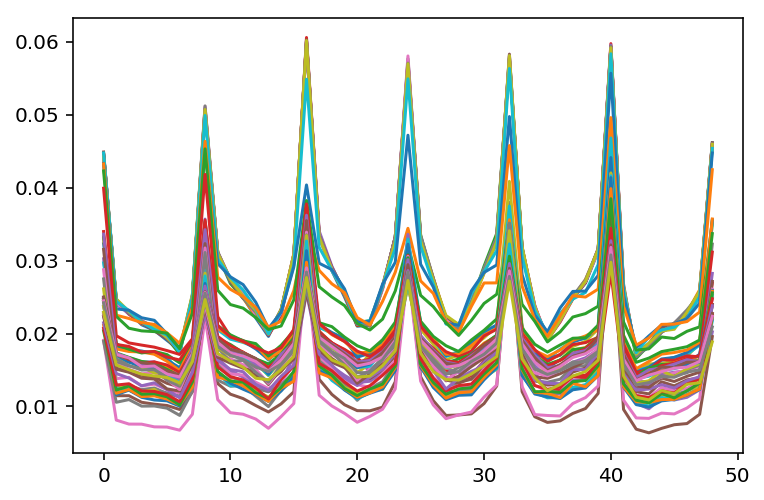

In [14]:
plt.plot(raw_data[:,1:].T);

In [15]:
raw_data.shape

(49, 50)

The data file format is as follows:
* Each row corresponds to a time
* The first element of the row gives the time index of the measurement
* The remaining columns give the measurements for each time
* These are divided into seven blocks.
    - Call the block $i$
    - Within the block the measurements correspond to electrodes $j=1,\dots,8$, $j\neq i$
    - Pair $(i,j)$ represents passing a current between electrode $i$ and electrode $j$ and measuring the voltage.
    - The voltage is measured between the _reference_ electrode at $1$ and the electrode located at $1+i$

_Is there not one too many electrodes here? This implies at some point we measure the voltage between 1 and 2 based on a current driven between 1 and 2._

_Is there a linear independence problem here? I still think there might be._

In [16]:
def data_to_dict(data):
    res = {}
    for r in data:
        time = r[0]
        other_data = r[1:]
        res[time] = scale*other_data.reshape((7,7))
    return res

In [17]:
data_dict = data_to_dict(raw_data)
# quick check to make sure the data dict matches expectation
assert np.all(data_dict[1][0] == scale*raw_data[0][1:8])

In [18]:
dummy_data = np.load(os.path.join(dummy_data_file, 'obs.npy'))
dummy_true_field = np.load(os.path.join(dummy_data_file, 'theta.npy'))

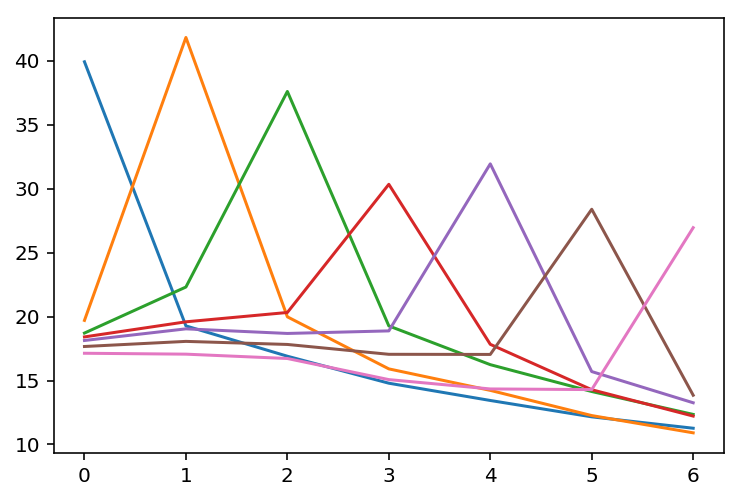

In [19]:
plt.plot(data_dict[run_time]);

# Set Up

In [20]:
s_x, s_xbar, s_y, s_ybar = sp.symbols('x,xbar,y,ybar')
a, a_x, a_y = sp.symbols('a,a_x,a_y')
a_bar, a_x_bar, a_y_bar = sp.symbols('abar,a_xbar,a_ybar')
s_length_scale, s_variance = sp.symbols('l,sigma')
kernel = s_variance*sp.exp(-((s_x-s_xbar)**2 + (s_y-s_ybar)**2) / (2.*s_length_scale**2))
symbols = [[s_x, s_y, a, a_x, a_y], [s_xbar, s_ybar, a_bar, a_x_bar, a_y_bar], [s_length_scale, s_variance]]

Use:
\begin{align*}
    \nabla \cdot (\exp(a)\nabla u) &= \nabla \exp(a) \cdot \nabla u + \exp(a) \nabla^2 u \\
    &= \exp(a) \left( \nabla a \cdot \nabla u + \nabla^2 u \right) \\
    &= \exp(a) \left( a_x u_x + a_y u_y + u_{xx} + u_{yy} \right)
\end{align*}
and:
\begin{align*}
    \exp(a) \nabla u \cdot n &= \exp(a) (x u_x + y u_y)
\end{align*}
for the special case of a unit circular domain centered at the origin.

## Define the collocation grid

In [21]:
n_in_shell = n_radii_forward
n_bdy = 32
n_sensor = 8
grid = hydrocyclone.grids.construct_circular(n_in_shell, n_bdy, n_sensor)

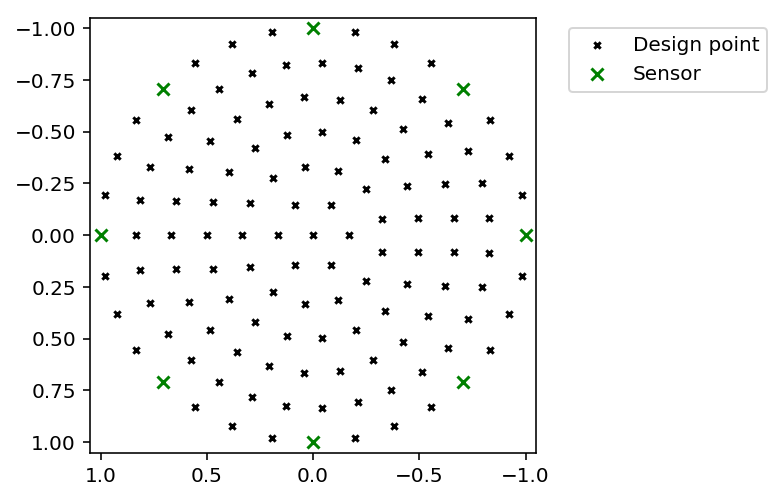

In [22]:
# plot design points
plt.figure(figsize=(4,4))
plt.scatter(grid.interior[:,0], grid.interior[:,1], marker='x', color='black', s=10)
plt.scatter(grid.boundary[:,0], grid.boundary[:,1], marker='x', color='black', s=10, label='Design point')
plt.scatter(grid.sensors[:,0], grid.sensors[:,1], marker='x', color='green', label='Sensor')
plt.xlim(1.05,-1.05);plt.ylim(1.05,-1.05)
plt.legend(loc=2, bbox_to_anchor=(1.05,1))

## Set up Proposal Matrix

In [23]:
proposal_kernel = kernel
def diff_x(k):
    return k.diff(s_x)
def diff_y(k):
    return k.diff(s_y)
def diff_x_bar(k):
    return k.diff(s_xbar)
def diff_y_bar(k):
    return k.diff(s_ybar)

proposal_op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [diff_x, diff_y], 
    [diff_x_bar, diff_y_bar], 
    proposal_kernel,
    [[s_x, s_y], [s_xbar, s_ybar], [s_length_scale, s_variance]]
)

In [24]:
proposal_design = hydrocyclone.grids.construct_shell(np.linspace(0,1,n_radii_inverse))

(1.05, -1.05)

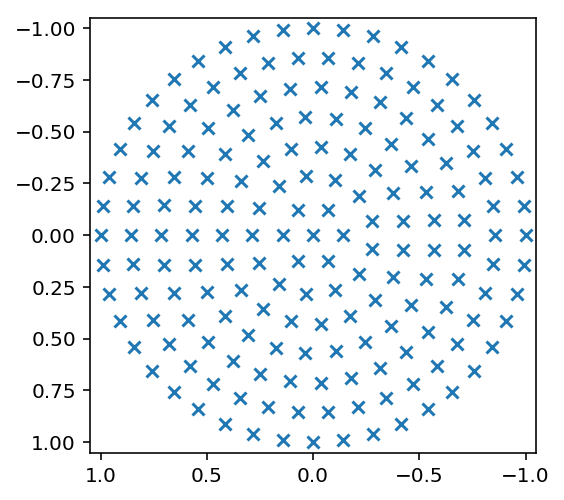

In [25]:

plt.figure(figsize=(4,4))
plt.scatter(proposal_design[:,0], proposal_design[:,1], marker='x')
plt.xlim(1.05,-1.05);plt.ylim(1.05,-1.05)

In [26]:
full_design = np.row_stack([grid.interior_plus_boundary, grid.sensors])
proposal_fun_args = np.array([conductivity_ls, conductivity_variance_mult])
proposal_cov = bpdes.collocation.compute_operator_matrix(
    [()],
    [()],
    [proposal_design],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_lhs_mat = bpdes.collocation.compute_operator_matrix(
    [(), diff_x, diff_y], 
    [()],
    [full_design, grid.interior_plus_boundary, grid.interior_plus_boundary],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_cov_inv = np.linalg.inv(proposal_cov)
np.linalg.cond(proposal_cov)

5646662752.2742453

/Users/jon/.virtualenvs/stats/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


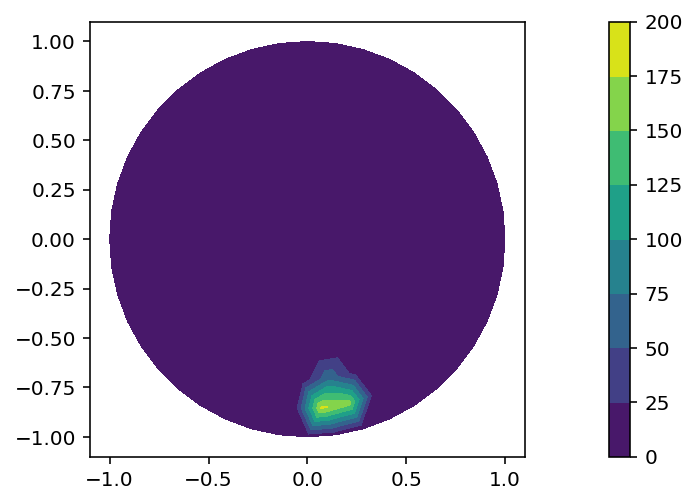

In [27]:
rhomin = 0.01
rho = baseline_fields[:,run_time-1][:,None]
rho[rho < rhomin] = rhomin
conduct = np.log(1./rho)
p = bpdes.collocate([()], [()], 
                    [(baseline_xy, conduct)],
                    proposal_op_system, 
                    np.array([0.12, 1.0]))

true_field, _ = p(proposal_design)
true_field = true_field.ravel()
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(true_field))

In [28]:
# TO DO:
# * Swap to simulating only a lower dimensional version of the field
proposal_dot_mat = np.dot(proposal_lhs_mat, proposal_cov_inv)

# Set Up The Potential

In [29]:
# todo: choose this in a more principled way
length_scale = kernel_ls
fun_args = np.array([kernel_ls, kernel_variance_mult])
data = data_dict[run_time] if not use_dummy_data else dummy_data


In [30]:
# choose an initial field
import scipy.optimize
def phi_const(k):
    theta = k*np.ones(proposal_cov.shape[0])
    return hydrocyclone.pcn_kernel.phi_c(grid, theta, likelihood_variance, pattern, data, fun_args, proposal_dot_mat)
    
best_const = scipy.optimize.minimize_scalar(phi_const)

In [31]:
# construct the proposal
beta = 0.05
if include_prior_mean:
    prior_mean = best_const.x*np.ones(proposal_cov.shape[0])
else:
    prior_mean = np.zeros(proposal_cov.shape[0])
sqrt_proposal_cov = np.real_if_close(linalg.sqrtm(proposal_cov))

proposal = mcmc.pcn.proposal(beta, proposal_cov, prior_mean)

pcn_kernel = eit.pcn_kernel.PCNKernel_C(beta, prior_mean, sqrt_proposal_cov, grid, likelihood_variance, pattern, data, fun_args, proposal_dot_mat)

In [32]:
if not restart:
    kappa_0 = best_const.x*np.ones(proposal_cov.shape[0])
else:
    seed_file = os.path.join(dest_dir, 'results.npy')
    kappa_0 = np.load(seed_file)[-1]

beta_0 = 0.05    

In [ ]:
print pcn_kernel.phi(kappa_0, debug=True, bayesian=bayesian)

In [ ]:
mu, cov = pcn_kernel.get_posterior(kappa_0, grid.sensors)
print np.dot(np.dot(meas_pattern, cov), meas_pattern.T)

In [ ]:
def ls_log_prior(ls):
    if ls < 0:
        return -np.inf
    return scipy.stats.halfcauchy.logpdf(ls)

In [ ]:
#kappa_0 = res[-1,:]
#length_scale = length_scales[-1]

In [ ]:
%%time
beta = beta_0
per_repeat = n_iter/thin
res = np.empty((per_repeat*n_repeats, kappa_0.shape[0]))

cur_length_scale = length_scale
pcn_kernel.collocate_args = np.array([cur_length_scale, kernel_variance_mult])
length_scales = np.empty(n_repeats)
length_scale_proposals = np.empty(n_repeats)
accepts = np.zeros(n_repeats, dtype=np.bool)
length_scale_proposal_variance = 1e-3
cur_ls_log_prior = ls_log_prior(length_scale)

start = kappa_0.reshape((1, kappa_0.shape[0]), order='F')

average_time = 0.
for i in xrange(n_repeats):
    init_time = time.time()
    proposals, acceptances, log_likelihoods = pcn_kernel.apply(start, n_iter, n_threads=8, beta=beta, bayesian=bayesian)
    took = time.time() - init_time
    average_time = (average_time * (i) + took) / (i+1)
    if acceptances.mean() < min_accept:
        beta *= 0.75
    elif acceptances.mean() > max_accept:
        beta /= 0.75
    if beta > 1:
        beta = 1.
    res[per_repeat*i:per_repeat*(i+1)] = proposals[::thin]
    start = proposals[-1,:].reshape(start.shape, order='F')
    
    if adapt_ls:
        # propose to change length_scale
        new_length_scale = np.random.normal(cur_length_scale, length_scale_proposal_variance)
        length_scale_proposals[i] = new_length_scale
        new_ls_log_prior = ls_log_prior(new_length_scale)

        if np.isneginf(new_ls_log_prior):
            accept = False
        else:
            cur_phi = pcn_kernel.phi(start.ravel())
            new_phi = pcn_kernel.phi(start.ravel(), np.array([new_length_scale, kernel_variance_mult]))
            accept_prob = np.exp(cur_phi - new_phi + new_ls_log_prior - cur_ls_log_prior)
            accept = np.random.uniform() < accept_prob
        if accept:
            cur_length_scale = new_length_scale
            cur_ls_log_prior = new_ls_log_prior
            pcn_kernel.collocate_args = np.array([cur_length_scale, kernel_variance_mult])
    else:
        accept = False
    accepts[i] = accept
    length_scales[i] = cur_length_scale
    if i > 100:
        if np.mean(accepts[i-99:i+1]) < min_accept:
            length_scale_proposal_variance *= 0.75
        elif np.mean(accepts[i-99:i+1]) > max_accept:
            length_scale_proposal_variance /= 0.75
        
    if i % 100 == 0:
        print '{}: accept={} beta={} ls={} accept={} t/iter={:.2}s'.format(i, acceptances.mean(), beta, cur_length_scale, np.mean(accepts[:i+1]), average_time)
#print log_likelihoods.mean()

In [ ]:
plt.plot(res[4000:,4])

In [ ]:
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(np.mean(res[40000:], axis=0)))

In [ ]:
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
np.save(os.path.join(dest_dir, 'results.npy'), res)
np.save(os.path.join(dest_dir, 'length_scales.npy'), length_scales)
np.save(os.path.join(dest_dir, 'field_pts.npy'), proposal_design)

plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(np.mean(res[40000:], axis=0)))
plt.savefig(os.path.join(dest_dir, 'mean.pdf'), bbox_inches=0, transparent=True)
plt.close()